In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


products = pd.read_csv("../data/olist_products_dataset.csv")
order_items = pd.read_csv("../data/olist_order_items_dataset.csv")
reviews = pd.read_csv("../data/olist_order_reviews_dataset.csv")

print("Datasets cargados.")


Datasets cargados.


In [2]:
price_per_product = (
    order_items.groupby("product_id")["price"]
               .mean()
               .reset_index()
)


In [3]:
reviews_per_product = (
    reviews.merge(order_items[["order_id", "product_id"]], on="order_id", how="left")
           .groupby("product_id")["review_score"]
           .mean()
           .reset_index()
)


In [4]:
product_features = products.merge(price_per_product, on="product_id", how="left") \
                           .merge(reviews_per_product, on="product_id", how="left")

product_features.head()


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,review_score
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,10.91,5.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,248.00,5.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0,79.80,5.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0,112.30,1.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0,37.90,5.0


In [5]:
features = product_features[[
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm",
    "price",
    "review_score"
]]


In [6]:
features = features.fillna(features.median())

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


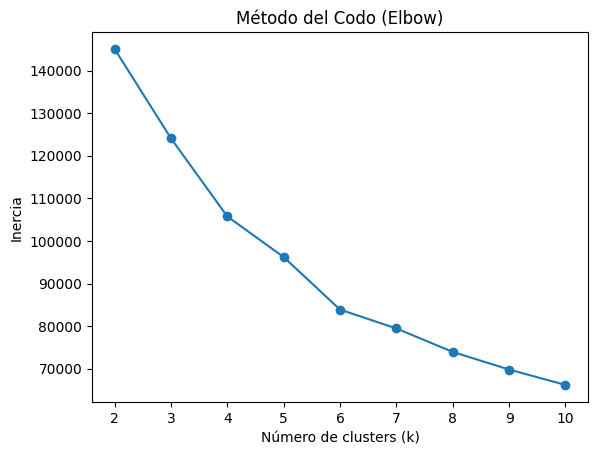

In [7]:
inertias = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 11), inertias, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del Codo (Elbow)")
plt.show()


In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
product_features["cluster"] = kmeans.fit_predict(features_scaled)

product_features["cluster"].value_counts()


cluster
1    17030
0     8063
2     5626
3     2232
Name: count, dtype: int64

In [9]:
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

product_features["pca_1"] = components[:, 0]
product_features["pca_2"] = components[:, 1]


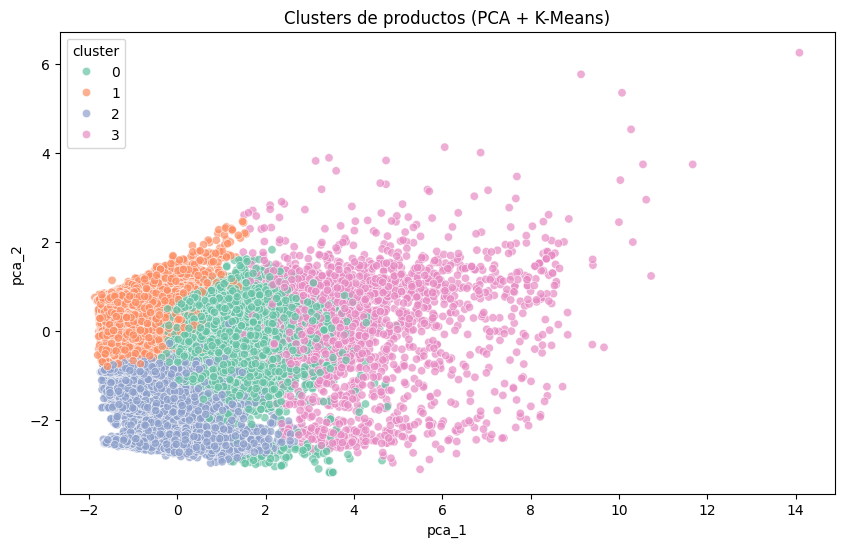

In [10]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=product_features,
    x="pca_1",
    y="pca_2",
    hue="cluster",
    palette="Set2",
    alpha=0.7
)
plt.title("Clusters de productos (PCA + K-Means)")
plt.show()


In [11]:
product_features.groupby("cluster")[features.columns].mean()


,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,review_score
cluster,,,,,,
0,2941.899913,46.983133,19.339204,33.735458,142.159949,4.384009
1,692.142178,22.018616,12.791755,17.000117,107.040692,4.609418
2,1096.375044,26.054924,14.814788,20.011554,117.113944,1.964584
3,14934.117384,51.515681,45.242384,40.428763,519.641487,3.831864
